In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from tqdm import tqdm

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# DRR utility functions
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=100, delx=10.):
    """Detector parameters -> DRR"""
    detector = Detector(
        sdr    = sdr,
        theta  = theta,
        phi    = phi,
        gamma  = gamma,
        bx     = bx,
        by     = by,
        bz     = bz,
        device = device
    )
    source, rays = detector.make_xrays(height, height, delx, delx)
    drr = siddon.raytrace(source, rays)
    return drr, detector.angles, detector.translation

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()
    
def corr(drr, est):
    x = xcorr2()
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1))
    return loss

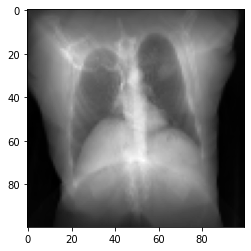

In [3]:
# Get the ground truth DRR
theta = torch.pi
phi = 0
gamma = torch.pi / 2
bx = 180
by = 180
bz = 166.25

drr, _, _ = make_drr(theta, phi, gamma, bx, by, bz)
plot(drr)

10.677648124558722 12.95320830332188 10.61589077816253


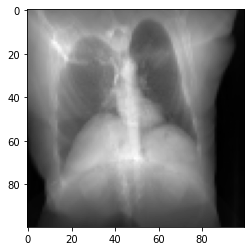

tensor([[[0.8655]]], device='cuda:0', grad_fn=<DivBackward0>)


In [4]:
x = np.random.uniform(-30., 31.)
y = np.random.uniform(-30., 31.)
z = np.random.uniform(-30., 31.)
# t = np.random.uniform(-np.pi/4, np.pi/4)
# p = np.random.uniform(-np.pi/4, np.pi/4)
# g = np.random.uniform(-np.pi/8, np.pi/8)
t = 0
p = 0
g = 0

print(x, y, z)

est, angles, trans = make_drr(theta+t, phi+p, gamma+g, bx+x, by+y, bz+z)
plot(est)

loss = torch.norm(drr - est, 1)
print(corr(drr, est))
loss.backward(retain_graph=True)
alpha = 1e-7

190.3516082763672 191.65826416015625 176.6731719970703
tensor([[[0.8813]]], device='cuda:0', grad_fn=<DivBackward0>)


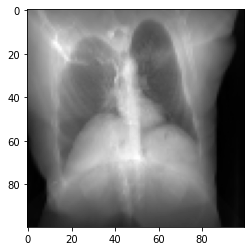

189.94876098632812 190.4198760986328 176.50369262695312
tensor([[[0.8953]]], device='cuda:0', grad_fn=<DivBackward0>)


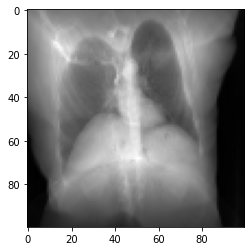

189.4974822998047 189.15695190429688 176.271728515625
tensor([[[0.9089]]], device='cuda:0', grad_fn=<DivBackward0>)


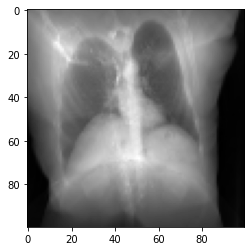

188.93496704101562 188.0782928466797 175.94235229492188
tensor([[[0.9207]]], device='cuda:0', grad_fn=<DivBackward0>)


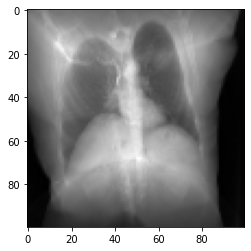

188.1653594970703 187.30325317382812 175.6080322265625
tensor([[[0.9304]]], device='cuda:0', grad_fn=<DivBackward0>)


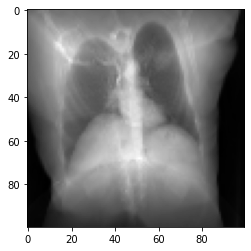

187.39622497558594 186.5227813720703 175.2033233642578
tensor([[[0.9400]]], device='cuda:0', grad_fn=<DivBackward0>)


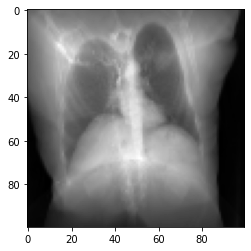

186.6204376220703 185.74012756347656 174.79542541503906
tensor([[[0.9491]]], device='cuda:0', grad_fn=<DivBackward0>)


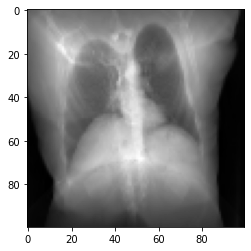

185.84104919433594 184.92115783691406 174.31910705566406
tensor([[[0.9578]]], device='cuda:0', grad_fn=<DivBackward0>)


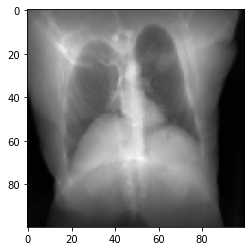

185.04840087890625 184.12713623046875 173.7580108642578
tensor([[[0.9659]]], device='cuda:0', grad_fn=<DivBackward0>)


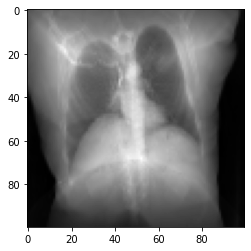

184.26315307617188 183.47900390625 173.13482666015625
tensor([[[0.9729]]], device='cuda:0', grad_fn=<DivBackward0>)


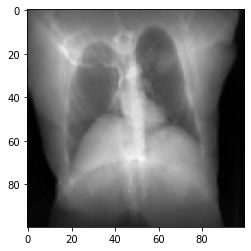

In [5]:
for _ in range(10):
    x, y, z = trans - alpha * trans.grad
    x = x.item()
    y = y.item()
    z = z.item()
    # print(bx - x, by - y, bz - z)
    print(x, y, z)

    est, angles, trans = make_drr(theta, phi, gamma, x, y, z)
    loss = torch.norm(drr - est, 1)
    print(corr(drr, est))

    loss.backward(retain_graph=True)

    plot(est)